In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import string
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import SnowballStemmer

In [2]:
df = pd.read_csv("../data/Youtube-Spam-Dataset.csv")
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [3]:
df_copy = df[['CONTENT', 'CLASS']]
df_copy.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [4]:
label_counts = df_copy['CLASS'].value_counts()
label_counts

CLASS
1    1005
0     951
Name: count, dtype: int64

In [5]:
df_copy['content_lowercase'] = df_copy['CONTENT'].str.lower()
df_copy.head()

C:\Users\prada\AppData\Local\Temp\ipykernel_26496\1627129950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_lowercase'] = df_copy['CONTENT'].str.lower()


,CONTENT,CLASS,content_lowercase
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿


In [ ]:
import re
import html

def remove_noise(text):
    '''Remove unwanted characters while preserving important features for spam/ham classification'''
    
    if not text or pd.isna(text):
        return ''
    
    text = str(text)
    
    # Decode HTML entities like &amp;, &lt;, &gt;
    text = html.unescape(text)
    
    # Remove HTML tags first
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Replace emails with token
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAILADDRESS ', text)
    
    # Crypto/wallet addresses (long random strings)
    text = re.sub(r'\b[a-zA-Z0-9]{25,}\b', ' CRYPTOADDRESS ', text)

    # Handle spaced domains BEFORE general URL detection
    # "kidsmediausa .com" → "kidsmediausa.com" (more targeted)
    text = re.sub(
    r'([a-zA-Z0-9_-]+)\s*\.\s*(com|net|org|id|co|uk|info|biz)\s*(/[^\s]*)?', 'URL',
    text)

    text = re.sub(
    r'\b(?:https?://|www\.)?[\w.-]+\.[a-z]{2,}(?:/[^\s]*)*',
    ' URL ',
    text,
    flags=re.IGNORECASE
)

    # Replace URLs with contextual tokens (preserve the spam signal)
    # Full URLs
    text = re.sub(
        r'''(?ix)
        \b(?:https?:?/?/?|http:?/?/?|www\.)
        [\w\-]+(\.[\w\-.]+)+
        (/[^\s]*)?
        ''',
        ' URL ',
        text
    )
    
    # Shortened URLs
    text = re.sub(
        r'\b(?:bit|adf|tinyurl|rebrand|shorturl|is\.gd|shorte|cutt|t\.co|lnkd)\.(?:ly|me|com|co|gd|io)(?:/\S*)?',
        ' URL ',
        text
    )
    
    # YouTube video links
    text = re.sub(r'watch\?v=\S+', ' URL ', text)
    
    # Domain-only patterns (common in spam)
    text = re.sub(r'\b[a-zA-Z0-9_-]+\.(?:com|net|org|id|co|uk)\b', ' URL ', text)
    

    
    # Replace ordinal numbers
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'NUM', text)
    
    # Replace various number formats with more specific tokens
    # Ganti semua angka dan angka+huruf satuan menjadi NUM
    text = re.sub(
    r'\b\d+(\.\d+)?([eE][+-]?\d+)?([a-zA-Z]+)?\b',
    'NUM',
    text)

    # Remove repetitive symbols (e.g., â–Œ repeated multiple times)
    text = re.sub(r'(\W)\1+', r'\1', text)  # Replace repeated non-word characters with a single one

    # Hapus emotikon seperti :) :p :( :D :-P dll
    text = re.sub(r'[:;=xX8][-~^]?[)(dDPpOo3|/\\]', ' ', text)

    # Fix separated letters but preserve intentional spacing for emphasis
    # "d-d-d-d" → "dddd" (stammering pattern)
    text = re.sub(r'\b([a-zA-Z])-([a-zA-Z])-([a-zA-Z]+(?:-[a-zA-Z])*)\b', 
                  lambda m: m.group(0).replace('-', ''), text)
    
    # "p e a c e" → "peace" but only if it's clearly unintentional
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z]+(?:\s+[a-zA-Z])*)\b',
                  lambda m: m.group(0).replace(' ', ''), text)
    
    # Remove BOM and problematic Unicode
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    
    # Remove BOM and all non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Removes characters like ï»¿ or emojis
    
    # Clean up excessive special characters (but keep our tokens)
    # Remove everything except letters, numbers, spaces, and our preserved tokens
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Normalize repeated characters (but preserve our spam indicators)
    # "hellooooo" → "helloo" (reduce but don't eliminate completely)
    text = re.sub(r'([a-zA-Z])\1{3,}', r'\1\1', text)
    
    # Consolidate multiple instances of our tokens
    text = re.sub(r'\b(NUM)(\s+\1)+\b', r'\1', text)
    
    # Final whitespace cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [ ]:
import re
import html
import pandas as pd

def detect_urls_comprehensive(text):
    """
    Fungsi untuk mendeteksi SEMUA jenis URL dengan pattern yang lebih agresif
    """
    if not text or pd.isna(text):
        return ''
    
    text = str(text)
    original_text = text  # Simpan untuk debugging
    
    # Decode HTML entities dulu
    text = html.unescape(text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # List untuk tracking URL yang ditemukan (untuk debugging)
    found_urls = []
    
    # 1. HANDLE SPACED DOMAINS FIRST (harus duluan!)
    # "example . com" atau "example .com" atau "example. com"
    spaced_domain_pattern = r'([a-zA-Z0-9][a-zA-Z0-9-_]*)\s*\.\s*([a-zA-Z]{2,}(?:\.[a-zA-Z]{2,})?)'
    matches = re.finditer(spaced_domain_pattern, text, re.IGNORECASE)
    for match in matches:
        found_urls.append(f"Spaced domain: {match.group()}")
    text = re.sub(spaced_domain_pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 2. Full URLs dengan protocol
    full_url_pattern = r'(?:https?:\/\/|ftp:\/\/|www\.)[^\s<>"{}|\\^`\[\]]+(?:[a-zA-Z0-9\/])'
    matches = re.finditer(full_url_pattern, text, re.IGNORECASE)
    for match in matches:
        found_urls.append(f"Full URL: {match.group()}")
    text = re.sub(full_url_pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 3. URLs tanpa protocol tapi dengan path
    # example.com/path atau example.co.id/something
    url_with_path = r'\b[a-zA-Z0-9][a-zA-Z0-9-]*(?:\.[a-zA-Z0-9][a-zA-Z0-9-]*)*\.[a-zA-Z]{2,}(?:\/[^\s]*)?'
    matches = re.finditer(url_with_path, text, re.IGNORECASE)
    for match in matches:
        found_urls.append(f"URL with path: {match.group()}")
    text = re.sub(url_with_path, ' URL ', text, flags=re.IGNORECASE)
    
    # 4. Domains saja (termasuk subdomain)
    # mail.google.com, shop.tokopedia.com
    domain_pattern = r'\b(?:[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?\.)+[a-zA-Z]{2,}\b'
    matches = re.finditer(domain_pattern, text, re.IGNORECASE)
    for match in matches:
        found_urls.append(f"Domain: {match.group()}")
    text = re.sub(domain_pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 5. Shortened URLs
    shorteners = [
        'bit.ly', 'tinyurl.com', 'goo.gl', 't.co', 'short.link', 
        'cutt.ly', 'ow.ly', 'is.gd', 'buff.ly', 'adf.ly',
        'bc.vc', 'bit.do', 'mcaf.ee', 'su.pr', 'fur.ly'
    ]
    for shortener in shorteners:
        pattern = rf'\b{re.escape(shortener)}\/[^\s]*'
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            found_urls.append(f"Shortened: {match.group()}")
        text = re.sub(pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 6. YouTube specific
    youtube_patterns = [
        r'youtube\.com\/watch\?v=[^\s]+',
        r'youtu\.be\/[^\s]+',
        r'youtube\.com\/channel\/[^\s]+',
        r'youtube\.com\/c\/[^\s]+',
        r'youtube\.com\/user\/[^\s]+'
    ]
    for pattern in youtube_patterns:
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            found_urls.append(f"YouTube: {match.group()}")
        text = re.sub(pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 7. Social media patterns
    social_patterns = [
        r'(?:instagram\.com|instagr\.am)\/[^\s]+',
        r'facebook\.com\/[^\s]+',
        r'fb\.com\/[^\s]+',
        r'twitter\.com\/[^\s]+',
        r'x\.com\/[^\s]+',  # Twitter baru
        r'linkedin\.com\/[^\s]+',
        r'tiktok\.com\/[^\s]+'
    ]
    for pattern in social_patterns:
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            found_urls.append(f"Social: {match.group()}")
        text = re.sub(pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 8. E-commerce Indonesia
    ecommerce_patterns = [
        r'tokopedia\.com\/[^\s]*',
        r'shopee\.co\.id\/[^\s]*',
        r'bukalapak\.com\/[^\s]*',
        r'lazada\.co\.id\/[^\s]*',
        r'blibli\.com\/[^\s]*'
    ]
    for pattern in ecommerce_patterns:
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            found_urls.append(f"E-commerce: {match.group()}")
        text = re.sub(pattern, ' URL ', text, flags=re.IGNORECASE)
    
    # 9. Any word ending with common TLDs (aggressive)
    tlds = ['com', 'net', 'org', 'id', 'co.id', 'ac.id', 'go.id', 'or.id', 
            'biz', 'info', 'name', 'tv', 'cc', 'me', 'ly', 'fm', 'io', 
            'co', 'uk', 'de', 'fr', 'ru', 'cn', 'jp', 'au', 'us', 'in',
            'online', 'store', 'tech', 'site', 'website', 'link']
    
    tld_pattern = r'\b[a-zA-Z0-9][a-zA-Z0-9-_]*\.(?:' + '|'.join(re.escape(tld) for tld in tlds) + r')\b'
    matches = re.finditer(tld_pattern, text, re.IGNORECASE)
    for match in matches:
        found_urls.append(f"TLD match: {match.group()}")
    text = re.sub(tld_pattern, ' URL ', text, flags=re.IGNORECASE)
    
    return text, found_urls

# Test function untuk debugging
def test_url_detection():
    test_cases = [
        "Check out example.com for more info",
        "Visit example . com now!",
        "Go to www.example.com/path/to/page",
        "https://example.com/test",
        "bit.ly/abc123",
        "youtube.com/watch?v=dQw4w9WgXcQ",
        "Follow us on instagram.com/mypage",
        "Shop at tokopedia.com/myshop",
        "Email me at test@email.com",
        "example .com is spaced",
        "subdomain.example.co.id/path",
        "just-a-domain.net",
        "Check my-site.online today",
        "Visit our store.shopee.co.id/promo"
    ]
    
    print("URL Detection Test Results:")
    print("-" * 80)
    
    for test in test_cases:
        cleaned, urls_found = detect_urls_comprehensive(test)
        print(f"\nOriginal: {test}")
        print(f"Cleaned:  {cleaned}")
        if urls_found:
            print("Found URLs:")
            for url in urls_found:
                print(f"  - {url}")
    
    return None


IndentationError: expected an indented block after function definition on line 106 (1297834282.py, line 107)

In [ ]:

# Fungsi cleaning lengkap dengan URL detection yang diperbaiki
def remove_noise_fixed(text):
    '''Remove unwanted characters with improved URL detection'''
    
    if not text or pd.isna(text):
        return ''
    
    text = str(text)
    
    # Decode HTML entities
    text = html.unescape(text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # CRITICAL: Detect URLs FIRST before other replacements
    text, _ = detect_urls_comprehensive(text)
    
    # Replace emails with token
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' EMAILADDRESS ', text)
    
    # Continue with other cleaning...
    # (rest of the cleaning code)
    
    return text


In [18]:
print(remove_noise1("&quot;HELP THE HUMANITY WITH YOUR SIGN IN TO THIS LINK WITH YOUR WHOLEHEARTED SUPPORT IF YOU SAY &quot;NO&quot; TO DISCRIMINATION. “UNITED WE STAND “  WE WILL BRING THE CHANGE TOGETHER.  IMPOSSIBLE ITSELF SAYS I  M  POSSIBLE&quot;  YOU ARE THE WINNERS OF MY SUCCESS!CHEERS TO ALL MY LOVING BROTHERS AND SISTERS !  PLEASE SHARE THIS LINK ON FACEBOOK TO SUPPORT AGAINST DISCRIMINATION.  tinyurl(dot)com(slash)mxh2y77  FEAR NONE BUT GOD !!!"))

help the humanity with your sign in to this link with your wholehearted support if you say no to discrimination. united we stand we will bring the change together. impossible itself says i m possible you are the winners of my success!cheers to all my loving brothers and sisters ! please share this link on facebook to support against discrimination. tinyurl dot com slash mxh2y77 fear none but god !


In [10]:
df_copy['content_lowercase_rn'] = df_copy['content_lowercase'].apply(remove_noise)
df_copy.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13360\2536906138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_lowercase_rn'] = df_copy['content_lowercase'].apply(remove_noise)


,CONTENT,CLASS,content_lowercase,content_lowercase_rn
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out


In [54]:
df_copy.to_csv("../data/Cleanrn1.csv", index=False)

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
def word_tokenization(text):
  return word_tokenize(text)

In [12]:
df_copy['content_tokenization'] = df_copy['content_lowercase_rn'].apply(word_tokenization)
df_copy.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13360\1013880177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_tokenization'] = df_copy['content_lowercase_rn'].apply(word_tokenization)


,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ..."
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]"


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
nltk.download('stopwords')

def remove_stopwords(text): 
    """Menghapus stopword dari list kata yang diberikan."""
    stops = set(stopwords.words("english"))
    
    if isinstance(text, list):
        text = [w for w in text if w.lower() not in stops]
        
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
print(stopwords.words("english"))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [14]:
df_copy['content_stopword'] = df_copy['content_tokenization'].apply(remove_stopwords)
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]"


In [15]:
# Inisialisasi stemmer untuk bahasa Inggris
stemmer = SnowballStemmer("english")

# Fungsi untuk stemming setiap kata dalam list
def stemmed_wrapper(document): 
    return [stemmer.stem(term) for term in document]

In [16]:
df_copy['content_steem'] = df_copy['content_stopword'].apply(stemmed_wrapper)
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword,content_steem
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u...","[hey, guy, check, new, channel, first, vid, us..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy]","[shake, sexi, ass, channel, enjoy]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]","[url, check]"


In [17]:
df_copy['content_clean'] = df_copy['content_steem']
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword,content_steem,content_clean
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u...","[hey, guy, check, new, channel, first, vid, us...","[hey, guy, check, new, channel, first, vid, us..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy]","[shake, sexi, ass, channel, enjoy]","[shake, sexi, ass, channel, enjoy]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]","[url, check]","[url, check]"


In [18]:
df_copy.to_csv("../data/Cleanfixskripsi.csv", index=False)

In [21]:
# Select columns by name to avoid IndexError
df_new = df_copy[['CLASS', 'content_clean']]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLASS          1956 non-null   int64 
 1   content_clean  1956 non-null   object
dtypes: int64(1), object(1)
memory usage: 30.7+ KB


In [23]:
label = df_new['CLASS']

In [24]:
label.head()

0    1
1    1
2    1
3    1
4    1
Name: CLASS, dtype: int64

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()
# Gabungkan token menjadi string sebelum TF-IDF
content_clean_str = df_new['content_clean'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else str(tokens))
tfidf_matrix = tf.fit_transform(content_clean_str.values)
tfidf_matrix.shape
matriks = tfidf_matrix.todense()
df_tfidf_filter = pd.DataFrame(matriks, columns=tf.get_feature_names_out(), index=df_new.index)

In [31]:
tfidf_filter = pd.concat([df_tfidf_filter,label], axis=1)

In [32]:
df_tfidf_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Columns: 2910 entries, 10 to zombi
dtypes: float64(2910)
memory usage: 43.4 MB


In [33]:
tfidf_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Columns: 2911 entries, 10 to CLASS
dtypes: float64(2910), int64(1)
memory usage: 43.4 MB


# TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Membuat objek TfidfVectorizer
tf = TfidfVectorizer()

# Gabungkan token menjadi string sebelum TF-IDF
content_clean_str = df_new['content_clean'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else str(tokens))
tfidf_matrix = tf.fit_transform(content_clean_str.values)

# Mendapatkan bentuk matriks (jumlah dokumen, jumlah kata)
print(f"Shape of the TF-IDF matrix: {tfidf_matrix.shape}")

# Mengonversi matriks TF-IDF ke dense matrix
matriks = tfidf_matrix.todense()

# Mengonversi dense matrix menjadi DataFrame dan menetapkan kolom dan indeks
df_tfidf = pd.DataFrame(matriks, columns=tf.get_feature_names_out(), index=df_copy.index)

tfidf_filter = pd.concat([df_tfidf_filter,label], axis=1)

# Menampilkan hasil DataFrame TF-IDF
print(df_tfidf)


Shape of the TF-IDF matrix: (1956, 2910)
       10  108k  128gb  12year  14gkvdo  16gb  17yr   1b  1bi  1billiom  ...  \
0     0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
1     0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
2     0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
3     0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
4     0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
...   ...   ...    ...     ...      ...   ...   ...  ...  ...       ...  ...   
1951  0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
1952  0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
1953  0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
1954  0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   
1955  0.0   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0  ...   

In [47]:
# Save to CSV files
df_tfidf.to_csv('tfidf4.csv', index=False)

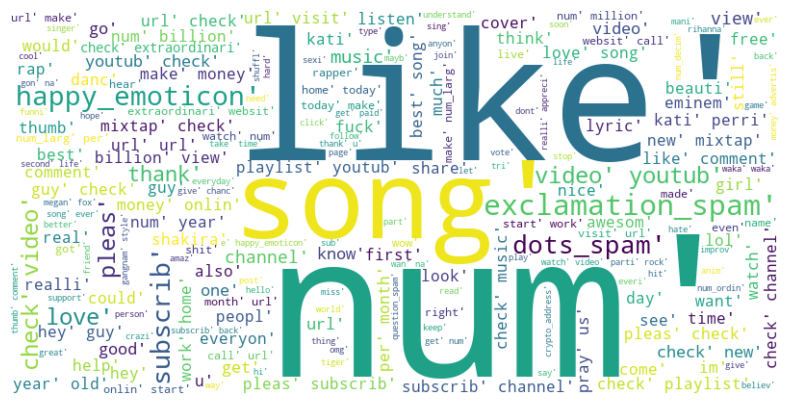

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua teks jadi satu string
text = " ".join(df_copy['content_clean'].dropna().astype(str))

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan gambar
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
